# Inverse covariance estimation with MFCF-LoGo.

## Generate data

In [15]:
import numpy as np
from scipy import linalg

def generate_spd_precision(n=5, density=0.2, eps=1e-8, prng=None):
    A = prng.random(size=(n, n)) * 1000
    precision = (A + A.T) / 2.0  # make symmetric

    # Sparsify (keep zeros symmetric; don't zero the diagonal)
    mask = prng.uniform(size=(n, n)) < density
    mask = np.triu(mask, k=1)  # keep strictly upper triangle
    mask = mask + mask.T
    np.fill_diagonal(mask, False)
    precision[mask] = 0.0

    # Diagonal loading: preserve ALL off-diagonal zeros, ensure PD
    min_eig = np.linalg.eigvalsh(precision).min()
    if min_eig <= eps:
        precision += (-min_eig + eps) * np.eye(n)

    return precision

n_samples = 100
n_features = 25
prng = np.random.RandomState(1)

prec = generate_spd_precision(n_features, density=0.8, prng=prng)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]

X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)

## Estimate the covariance and precision matrices

In [16]:
from sklearn.covariance import GraphicalLassoCV
from mfcf_logo import MFCFLoGoCV

emp_cov = np.dot(X.T, X) / n_samples

model = GraphicalLassoCV()
model.fit(X)
gl_cov_ = model.covariance_
gl_prec_ = model.precision_

# MFCFCV
model = MFCFLoGoCV(max_clique_size_grid=n_features)
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

/Users/yan/miniconda3/envs/HNN/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


## Plot the results

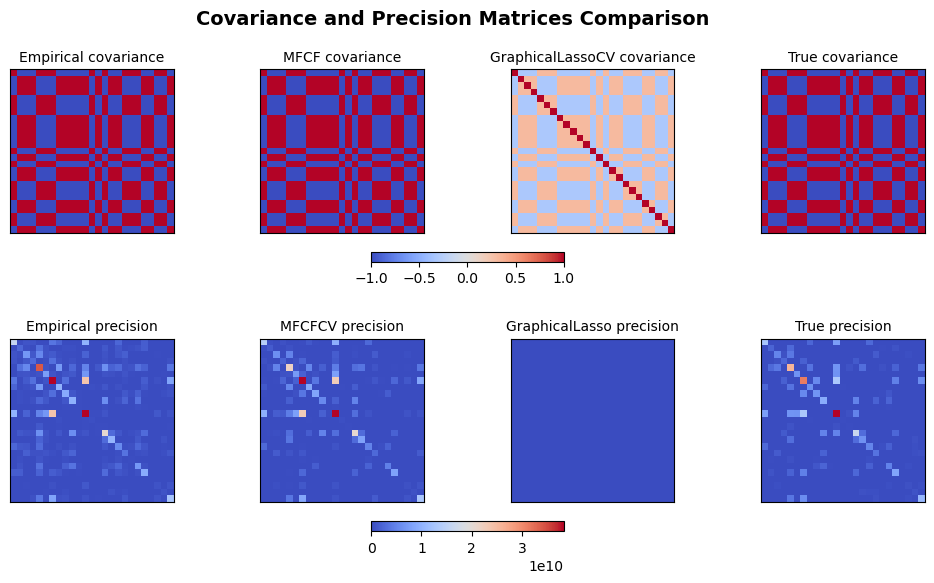

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.subplots_adjust(wspace=0.4, hspace=0.4)  # Add space between subplots

# Shared color scale for fair comparison
vmin, vmax = np.min(cov), np.max(cov)
pvmin, pvmax = np.min(prec), np.max(prec)

# Plot covariances
covs = [
    ("Empirical", emp_cov),
    ("MFCF", cov_),
    ("GraphicalLassoCV", gl_cov_),
    ("True", cov),
]
for i, (name, this_cov) in enumerate(covs):
    ax = axes[0, i]
    im = ax.imshow(this_cov, cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f"{name} covariance", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.colorbar(im, ax=axes[0, :], orientation='horizontal', fraction=0.05, pad=0.1)

# Plot precisions
precs = [
    ("Empirical", linalg.inv(emp_cov)),
    ("MFCFCV", prec_),
    ("GraphicalLasso", gl_prec_),
    ("True", prec),
]
for i, (name, this_prec) in enumerate(precs):
    ax = axes[1, i]
    im = ax.imshow(this_prec, cmap='coolwarm', interpolation='nearest', vmin=pvmin, vmax=pvmax)
    ax.set_title(f"{name} precision", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.colorbar(im, ax=axes[1, :], orientation='horizontal', fraction=0.05, pad=0.1)

fig.suptitle("Covariance and Precision Matrices Comparison", fontsize=14, fontweight='bold')
plt.show()

In [18]:
print(model.cv_results_)
print(f"Best max clique size: {model.best_max_clique_size_}")

{'params': [{'max_clique_size': 2}, {'max_clique_size': 3}, {'max_clique_size': 4}, {'max_clique_size': 5}, {'max_clique_size': 6}, {'max_clique_size': 7}, {'max_clique_size': 8}, {'max_clique_size': 9}, {'max_clique_size': 10}, {'max_clique_size': 11}, {'max_clique_size': 12}, {'max_clique_size': 13}, {'max_clique_size': 14}, {'max_clique_size': 15}, {'max_clique_size': 16}, {'max_clique_size': 17}, {'max_clique_size': 18}, {'max_clique_size': 19}, {'max_clique_size': 20}, {'max_clique_size': 21}, {'max_clique_size': 22}, {'max_clique_size': 23}, {'max_clique_size': 24}, {'max_clique_size': 25}], 'mean_test_score': array([217.90878333, 218.75172416, 218.87005318, 219.01330962,
       219.14585003, 219.07823618, 218.92186672, 218.9076738 ,
       218.73360569, 218.65400558, 218.46918652, 218.526625  ,
       218.49257268, 218.26549279, 218.13724069, 217.93371479,
       217.86473259, 217.89517485, 217.70162817, 217.66415312,
       217.69676765, 217.64091048, 217.60362092, 217.57945486

In [19]:
from sklearn.covariance import log_likelihood
print("MFCFCV log likelihood: %.3f" % log_likelihood(emp_cov, prec))
print("GraphicalLassoCV log likelihood: %.3f" % log_likelihood(emp_cov, gl_prec_))

MFCFCV log likelihood: 220.336
GraphicalLassoCV log likelihood: -21.907
